In [464]:
import random
random.seed(14318732)

In [465]:
import numpy as np
import pandas as pd
import copy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_auc_score, auc, accuracy_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
from torch import nn
import torch
import torch.nn.functional as F

# Clean Data

In [466]:
df = pd.read_csv('musicData.csv')
df.drop(['instance_id', 'artist_name', 'track_name', 'obtained_date'], axis = 1, inplace=True)

In [467]:
#impute duration_ms
df['duration_ms'].replace(-1, np.nan, inplace=True)
df['duration_ms'].fillna(df['duration_ms'].astype(float).mean(), inplace=True)

In [468]:
# categorize key
df['key'] = pd.factorize(df['key'])[0]

In [469]:
#mode to dummy
df['mode'].replace('Major', 1, inplace=True)
df['mode'].replace('Minor', 0, inplace=True)

In [470]:
#impute tempo
df['tempo'].replace('?', np.nan, inplace=True)
df['tempo'].fillna(df['tempo'].astype(float).mean(), inplace=True)

In [471]:
# categorize genre
df['music_genre'] = pd.factorize(df['music_genre'])[0]
df = df[df['music_genre'] != -1]

In [472]:
df['popularity'] = (df['popularity'] - df['popularity'].mean())/df['popularity'].std()
df['duration_ms'] = (df['duration_ms'] - df['duration_ms'].mean())/df['duration_ms'].std()
df['tempo'] = df['tempo'].astype('float')
df['tempo'] = (df['tempo'] - df['tempo'].mean())/df['tempo'].std()

In [473]:
df

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,-1.107992,0.00468,0.652,1.232533e-13,0.941,0.79200,0,0.115,-5.201,0.0,0.0748,-0.655667,0.759,0
1,-0.850625,0.01270,0.622,-2.572216e-01,0.890,0.95000,1,0.124,-7.043,0.0,0.0300,-0.170278,0.531,0
2,-1.043650,0.00306,0.620,-2.825557e-01,0.755,0.01180,2,0.534,-4.617,1.0,0.0345,0.276555,0.333,0
3,-0.657600,0.02540,0.774,-7.432766e-01,0.700,0.00253,3,0.157,-4.498,1.0,0.2390,0.277243,0.270,0
4,-0.786283,0.00465,0.638,-2.186911e-01,0.587,0.90900,4,0.157,-6.266,1.0,0.0413,0.862681,0.323,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,0.950944,0.03340,0.913,1.232533e-13,0.574,0.00000,3,0.119,-7.022,1.0,0.2980,-0.754065,0.330,9
50001,1.787387,0.15700,0.709,6.008768e-02,0.362,0.00000,5,0.109,-9.814,1.0,0.0550,0.071883,0.113,9
50002,0.436210,0.00597,0.693,-5.295629e-01,0.763,0.00000,1,0.143,-5.443,1.0,0.1460,0.382658,0.395,9
50003,1.336995,0.08310,0.782,1.632484e-01,0.472,0.00000,6,0.106,-5.016,0.0,0.0441,-1.515594,0.354,9


In [474]:
#split data
train_df = pd.DataFrame()
test_df = pd.DataFrame()

for genre in df['music_genre'].unique():
    genre_df = df[df['music_genre'] == genre].copy()
    train, test = train_test_split(genre_df, test_size=500, random_state=random.randint(0,1000))
    train_df = pd.concat([train_df, train])
    test_df = pd.concat([test_df, test])
    

assert set(train_df.index).isdisjoint(set(test_df.index))

In [475]:
X_train = train_df.drop('music_genre', axis=1)
X_test = test_df.drop('music_genre', axis=1)
y_train = train_df['music_genre']
y_test = test_df['music_genre']

# Dimension Reduction

In [476]:
lda = LinearDiscriminantAnalysis(n_components=9)

X_train_lda = lda.fit_transform(X_train,y_train)
X_test_lda = lda.transform(X_test)

/var/folders/fv/3lzl53fs1j31wyn24dcdgspw0000gn/T/ipykernel_82769/3836850800.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_train_lda[y_train==i, 0], X_train_lda[y_train==i, 1],c=c, label=label)


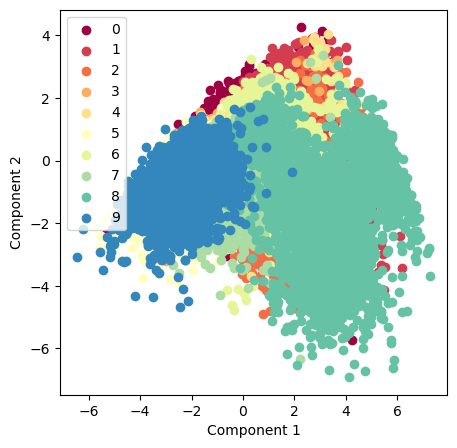

In [477]:
target_ids = range(10)
plt.figure(figsize=(5, 5))
for i, c, label in zip(target_ids, colors, df['music_genre'].unique()):
    plt.scatter(X_train_lda[y_train==i, 0], X_train_lda[y_train==i, 1],c=c, label=label)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

# Clustering

# Kmeans

In [478]:
clusterer = KMeans(10, n_init='auto')
labels = clusterer.fit_predict(X_train_lda)
X_kmeans_train = clusterer.predict(X_train_lda)
X_kmeans_test = clusterer.predict(X_test_lda)

a =np.unique(labels)
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

# DBSCAN

In [479]:
dbscan = DBSCAN(eps=2.2, min_samples=3)

# Fit the DBSCAN object to your data
dbscan.fit(X_train_lda)

# Obtain the cluster labels for your data
cluster_labels = dbscan.labels_
a =np.unique(cluster_labels)
a

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

/var/folders/fv/3lzl53fs1j31wyn24dcdgspw0000gn/T/ipykernel_82769/2957217414.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xy[:, 0], xy[:, 1], c=color)


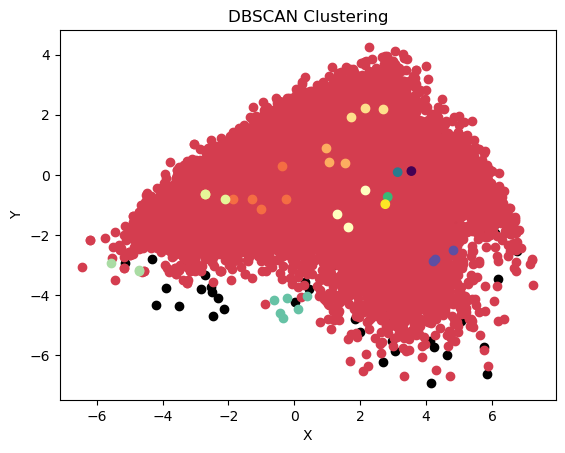

Amount of dots of cluster 0 is 44763


In [480]:
unique_labels = np.unique(cluster_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for label, color in zip(unique_labels, colors):
    if label == -1:
        # Black used for noise.
        color = 'k'
    class_member_mask = (cluster_labels == label)
    xy = X_train_lda[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=color)
plt.title('DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print('Amount of dots of cluster 0 is',np.count_nonzero(cluster_labels == 0))

# SVM

In [481]:
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_kmeans_train.reshape(-1,1), y_train)
# svm_pred = svm_model.predict(X_kmeans_test)

pred_proba_kmeans_svm = svm_model.predict_proba(X_kmeans_test.reshape(-1,1))
auc_score = roc_auc_score(y_test, pred_proba_kmeans_svm, multi_class='ovr')
print("AUC score of SVM on clustered data:", auc_score)

AUC score of SVM on clustered data: 0.8167958666666666


In [482]:
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_lda, y_train)
svm_pred = svm_model.predict(X_test_lda)

pred_proba_lda_svm = svm_model.predict_proba(X_test_lda)
auc_score = roc_auc_score(y_test, pred_proba_lda_svm, multi_class='ovr')
print("AUC score on data:", auc_score)


AUC score on data: 0.9267681777777778


In [483]:
accuracy_lda_svm = accuracy_score(y_test, svm_pred)
print('Accuracy of SVM on LDA data: {:.2f} %'.format(accuracy_lda_svm*100))

Accuracy of SVM on LDA data: 58.62 %


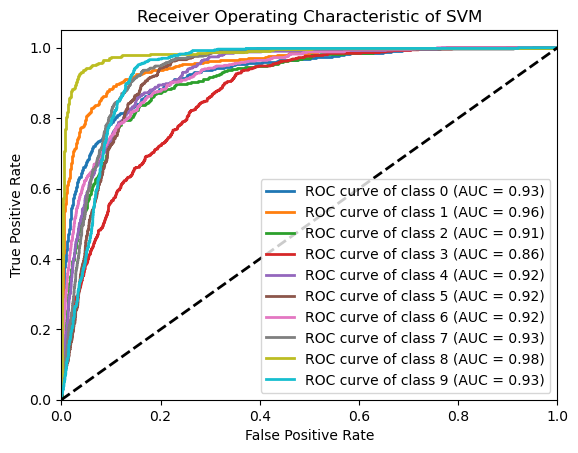

In [484]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], threshold = roc_curve(y_test, pred_proba_lda_svm[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in (range(10)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of SVM')
plt.legend(loc="lower right")
plt.show()

# Random Forest

In [485]:
rf = RandomForestClassifier(n_estimators=1000, max_samples=1.0, max_features=0.02,bootstrap=True, criterion='gini')
rf.fit(X_train_lda, y_train)
pred_prob_lda_rf = rf.predict_proba(X_test_lda)
rf_lda_pred = rf.predict(X_test_lda)
AUC = roc_auc_score(y_test, pred_prob_lda_rf, multi_class='ovo')
print('{:70s}{:.5f}'.format('AUC of Random Forest on LDA data is: ', AUC))

accuracy_lda_rf = accuracy_score(y_test, rf_lda_pred)
print('Accuracy of Random Forest on LDA data: ', accuracy_lda_rf*100, '%')

AUC of Random Forest on LDA data is:                                  0.90925
Accuracy of Random Forest on LDA data:  53.1 %


In [486]:
rf = RandomForestClassifier(n_estimators=1000, max_samples=1.0, max_features=0.02,bootstrap=True, criterion='gini')
rf.fit(X_train, y_train)
pred_prob_rf = rf.predict_proba(X_test)
rf_pred = rf.predict(X_test)
AUC = roc_auc_score(y_test, pred_prob_rf, multi_class='ovo')
print('{:70s}{:.5f}'.format('AUC of Random Forest is: ', AUC))

accuracy_rf = accuracy_score(y_test, rf_pred)
print('Accuracy of Random Forest on data: ', accuracy_rf*100, '%')

AUC of Random Forest is:                                              0.91229
Accuracy of Random Forest on data:  54.44 %


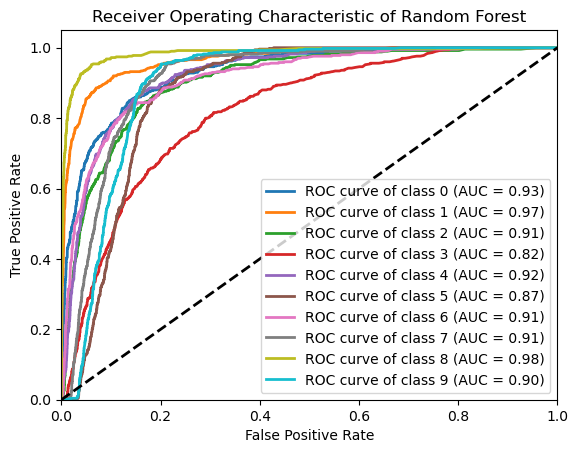

In [487]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], threshold = roc_curve(y_test, pred_prob_rf[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in (range(10)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Random Forest')
plt.legend(loc="lower right")
plt.show()

# Neural Network

In [488]:
learning_rate = 1e-1
lambda_l2 = 1e-3 # coefficient for the L2 regularizer. You should play with its value to see the effect of regularization

num_classes = len(np.unique(y_train))
num_features = np.shape(X_train_lda)[1]

D = num_features  # dimensions
C = num_classes  # num_classes
H = 100  # num_hidden_units

In [489]:
X_train_tensor = torch.tensor(X_train_lda.astype(np.float32))
X_test_tensor = torch.tensor(X_test_lda.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

model = nn.Sequential(
    nn.Linear(D, H),
    nn.ReLU(),
    nn.Linear(H,C)    
)

In [490]:
from IPython.display import clear_output
# nn package has a variety of loss functions already implemented
# we use cross entropy loss for our classification task
criterion = torch.nn.CrossEntropyLoss()

# nn package also has a variety of optimization algorithms implemented
# we use the stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
for t in range(100):
    
    # Forward pass over the model to get the logits
    y_pred = model(X_train_tensor)
    
    # Compute the loss and accuracy
    loss = criterion(y_pred, y_train_tensor)
    score, predicted = torch.max(y_pred, 1)
    acc = (y_train_tensor == predicted).sum().float() / len(y_train_tensor)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    clear_output(wait=True)
    
    # reset (zero) the gradients before running the backward pass over the model
    # we need to do this because the gradients get accumulated at the same place across iterations
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient of loss w.r.t our learnable params (weights and biases)
    loss.backward()
    
    # Update params
    optimizer.step()

[EPOCH]: 99, [LOSS]: 1.370536, [ACCURACY]: 0.512


In [491]:
Y_pred = model(X_test_tensor)
Y_pred_np = F.softmax(Y_pred, dim=1).detach().numpy()
y_test_np = y_test_tensor.numpy()
AUC = roc_auc_score(y_test_np, Y_pred_np, multi_class='ovr')

print('{:50s}{:.5f}'.format('AUC of NN with Linear activation function and 1 hidden layers: ', AUC))

AUC of NN with Linear activation function and 1 hidden layers: 0.89919


In [492]:
mlp = MLPClassifier(activation='tanh')
mlp.fit(X_train_lda, y_train)


pred_prob_mlp = mlp.predict_proba(X_test_lda)
y_pred = mlp.predict(X_test_lda)
accuracy_mlp = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy_mlp*100))
AUC_mlp = roc_auc_score(y_test, pred_prob_mlp, multi_class='ovr')
print('AUC:', AUC_mlp)

Accuracy: 57.98%
AUC: 0.9290430666666666


/Users/mariowang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


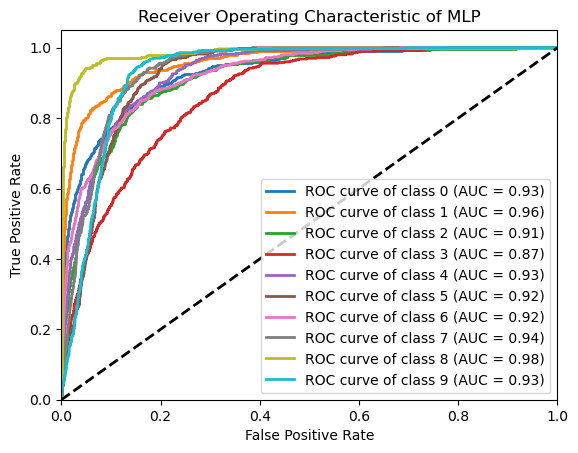

In [493]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], threshold = roc_curve(y_test, pred_prob_mlp[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in (range(10)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of MLP')
plt.legend(loc="lower right")
plt.show()